In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import sys
import warnings
import os
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from modeling_util import *
from modeling_helper import get_categorical_columns, get_numerical_columns, cross_validation, plot_result, label_encoder

In [24]:
df = pd.read_csv("../data/all_merged_cta_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         905 non-null    int64  
 1   game_id            905 non-null    object 
 2   cta_start_x        905 non-null    float64
 3   cta_start_y        905 non-null    float64
 4   cta_end_x          905 non-null    float64
 5   cta_end_y          905 non-null    float64
 6   cta_height         905 non-null    float64
 7   cta_width          905 non-null    float64
 8   color_1            900 non-null    object 
 9   color_1_occurance  900 non-null    float64
 10  color_2            898 non-null    object 
 11  color_2_occurance  898 non-null    float64
 12  color_3            898 non-null    object 
 13  color_3_occurance  898 non-null    float64
 14  color_4            897 non-null    object 
 15  color_4_occurance  897 non-null    float64
 16  color_5            894 non

In [47]:
df_game_id_ER_CTR = pd.DataFrame({
    'game_id':df['game_id'].to_list(),
    'ER':np.random.rand(905).tolist(),
    'CTR':np.random.rand(905).tolist()
})

In [48]:
df_game_id_ER_CTR

,game_id,ER,CTR
0,ed3071a667a11cc56e88ae0489bfe6aa,0.522940,0.975965
1,4799763419d621cd41e7fb8abbcdd45d,0.865483,0.474631
2,bf1f7af46eec0e92939a8b3ba51cbacd,0.369275,0.422719
3,e68e20f592457b875ce29757ab855dfe,0.015088,0.461712
4,6a8e741867d4f893afad015b77b52c39,0.255562,0.123088
...,...,...,...
900,8968a702d64524827de2ccf55c802d6c,0.960574,0.777629
901,adunit-showtime-dexture-mpu,0.913909,0.936009
902,79bb17ace9de9ef7def221cc38b50c0c,0.882153,0.196111
903,adunit-chanel-j12-tw-black-en-2022-mpu,0.754836,0.104904


In [49]:
df1 = pd.merge(df, df_game_id_ER_CTR, on='game_id')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         905 non-null    int64  
 1   game_id            905 non-null    object 
 2   cta_start_x        905 non-null    float64
 3   cta_start_y        905 non-null    float64
 4   cta_end_x          905 non-null    float64
 5   cta_end_y          905 non-null    float64
 6   cta_height         905 non-null    float64
 7   cta_width          905 non-null    float64
 8   color_1            900 non-null    object 
 9   color_1_occurance  900 non-null    float64
 10  color_2            898 non-null    object 
 11  color_2_occurance  898 non-null    float64
 12  color_3            898 non-null    object 
 13  color_3_occurance  898 non-null    float64
 14  color_4            897 non-null    object 
 15  color_4_occurance  897 non-null    float64
 16  color_5            894 non

#### Train first model for KPI prediction using CTA position, and Dominant Colors

In [103]:
df_model_1 = df1.copy()

df_model_1.columns.tolist()

['Unnamed: 0',
 'game_id',
 'cta_start_x',
 'cta_start_y',
 'cta_end_x',
 'cta_end_y',
 'cta_height',
 'cta_width',
 'color_1',
 'color_1_occurance',
 'color_2',
 'color_2_occurance',
 'color_3',
 'color_3_occurance',
 'color_4',
 'color_4_occurance',
 'color_5',
 'color_5_occurance',
 'logo_start_x',
 'logo_start_y',
 'logo_end_x',
 'logo_end_y',
 'logo_height',
 'logo_width',
 'ER',
 'CTR']

In [104]:
cols_to_be_dropped = [
    'logo_start_x',
    'logo_start_y',
    'logo_end_x',
    'logo_end_y',
    'logo_height',
    'logo_width'
    ]

df_model_1.drop(cols_to_be_dropped,inplace=True, axis=1)
df_model_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         905 non-null    int64  
 1   game_id            905 non-null    object 
 2   cta_start_x        905 non-null    float64
 3   cta_start_y        905 non-null    float64
 4   cta_end_x          905 non-null    float64
 5   cta_end_y          905 non-null    float64
 6   cta_height         905 non-null    float64
 7   cta_width          905 non-null    float64
 8   color_1            900 non-null    object 
 9   color_1_occurance  900 non-null    float64
 10  color_2            898 non-null    object 
 11  color_2_occurance  898 non-null    float64
 12  color_3            898 non-null    object 
 13  color_3_occurance  898 non-null    float64
 14  color_4            897 non-null    object 
 15  color_4_occurance  897 non-null    float64
 16  color_5            894 non

#### Normalize and Encode CTA position 

* We need to take a look at the coordinated befor deciding on the approach

In [105]:
df_model_1['cta_start_x'].describe()

count    905.000000
mean     213.731492
std      192.445084
min        0.000000
25%       74.000000
50%      166.000000
75%      328.000000
max      937.000000
Name: cta_start_x, dtype: float64

In [106]:
df_model_1['cta_start_y'].describe()

count    905.000000
mean     458.985635
std      312.875136
min        0.000000
25%      146.000000
50%      426.000000
75%      795.000000
max      889.000000
Name: cta_start_y, dtype: float64

* We can choose 300px as a separator for both `cta_start_x` & `cta_start_y`

In [107]:
def return_position_val(x,y):
    if x < 300 and y < 300:
        return "top_left"
    elif x < 300 and y < 600:
        return "center_left"
    elif x < 300 and y < 900:
        return "bottom_left"
    elif x < 600 and y < 300:
        return "top_center"
    elif x < 600 and y < 600:
        return "center"
    elif x < 600 and y < 900:
        return "bottom_center"
    elif x < 940 and y < 300:
        return "top_right"
    elif x < 940 and y < 600:
        return "top_center"
    else: return "bottom_right"

In [108]:
def encode_coordinates(df):
    encoded_val = []
    for i,row in df.iterrows():
        encoded_val.append(return_position_val(row['cta_start_x'],row['cta_start_y']))
    return encoded_val

In [109]:
def calc_area(df):
    area = []
    for i,row in df.iterrows():
        area.append(row['cta_width']*row['cta_height'])
    return area

In [110]:
df_model_1['cta_position'] = encode_coordinates(df_model_1)
df_model_1['cta_position'].value_counts()

top_left         283
bottom_left      257
bottom_center    122
center_left      109
top_center        77
center            31
top_right         14
bottom_right      12
Name: cta_position, dtype: int64

* Normalize height and width to an area

In [111]:
df_model_1['area'] = calc_area(df_model_1)
df_model_1['area'].describe()

count       905.000000
mean      40292.538122
std       94729.961811
min        1064.000000
25%       11700.000000
50%       17388.000000
75%       22500.000000
max      540000.000000
Name: area, dtype: float64

#### Drop all coordinate values since we normlaized and encoded them

In [112]:
cols = ['cta_start_x', 'cta_start_y', 'cta_end_x', 'cta_end_y',
       'cta_height', 'cta_width','Unnamed: 0',]
df_model_1.drop(cols, inplace=True, axis=1)
df_model_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_id            905 non-null    object 
 1   color_1            900 non-null    object 
 2   color_1_occurance  900 non-null    float64
 3   color_2            898 non-null    object 
 4   color_2_occurance  898 non-null    float64
 5   color_3            898 non-null    object 
 6   color_3_occurance  898 non-null    float64
 7   color_4            897 non-null    object 
 8   color_4_occurance  897 non-null    float64
 9   color_5            894 non-null    object 
 10  color_5_occurance  894 non-null    float64
 11  ER                 905 non-null    float64
 12  CTR                905 non-null    float64
 13  cta_position       905 non-null    object 
 14  area               905 non-null    float64
dtypes: float64(8), object(7)
memory usage: 113.1+ KB


In [113]:
df_model_1.dropna(inplace=True)
df_model_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 894 entries, 0 to 904
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_id            894 non-null    object 
 1   color_1            894 non-null    object 
 2   color_1_occurance  894 non-null    float64
 3   color_2            894 non-null    object 
 4   color_2_occurance  894 non-null    float64
 5   color_3            894 non-null    object 
 6   color_3_occurance  894 non-null    float64
 7   color_4            894 non-null    object 
 8   color_4_occurance  894 non-null    float64
 9   color_5            894 non-null    object 
 10  color_5_occurance  894 non-null    float64
 11  ER                 894 non-null    float64
 12  CTR                894 non-null    float64
 13  cta_position       894 non-null    object 
 14  area               894 non-null    float64
dtypes: float64(8), object(7)
memory usage: 111.8+ KB


In [ ]:
df_model_1.to_csv('../data/cta_color_cleaned.csv')


In [23]:
df_for_model = pd.read_csv('../data/cta_color_cleaned.csv')
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         894 non-null    int64  
 1   game_id            894 non-null    object 
 2   color_1            894 non-null    object 
 3   color_1_occurance  894 non-null    float64
 4   color_2            894 non-null    object 
 5   color_2_occurance  894 non-null    float64
 6   color_3            894 non-null    object 
 7   color_3_occurance  894 non-null    float64
 8   color_4            894 non-null    object 
 9   color_4_occurance  894 non-null    float64
 10  color_5            894 non-null    object 
 11  color_5_occurance  894 non-null    float64
 12  ER                 894 non-null    float64
 13  CTR                894 non-null    float64
 14  cta_position       894 non-null    object 
 15  area               894 non-null    float64
dtypes: float64(8), int64(1), o

In [24]:
df_for_model.drop(['Unnamed: 0'],inplace=True,axis=1)

In [25]:
numerical_cols = get_numerical_columns(df_for_model)
categorical_cols = get_categorical_columns(df_for_model)

In [26]:
numerical_cols

['color_1_occurance',
 'color_2_occurance',
 'color_3_occurance',
 'color_4_occurance',
 'color_5_occurance',
 'ER',
 'CTR',
 'area']

In [27]:
categorical_cols

['game_id',
 'color_1',
 'color_2',
 'color_3',
 'color_4',
 'color_5',
 'cta_position']

In [28]:
categorical_cols.remove('game_id')

In [29]:

categorical_cols_encoded = label_encoder(df_for_model)

In [30]:
categorical_cols_encoded.drop(columns=['game_id'], inplace=True)

In [31]:
X = df_for_model.copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   color_1            894 non-null    int64  
 1   color_1_occurance  894 non-null    float64
 2   color_2            894 non-null    int64  
 3   color_2_occurance  894 non-null    float64
 4   color_3            894 non-null    int64  
 5   color_3_occurance  894 non-null    float64
 6   color_4            894 non-null    int64  
 7   color_4_occurance  894 non-null    float64
 8   color_5            894 non-null    int64  
 9   color_5_occurance  894 non-null    float64
 10  ER                 894 non-null    float64
 11  CTR                894 non-null    float64
 12  cta_position       894 non-null    int64  
 13  area               894 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 97.9 KB


In [149]:
# X.drop(['game_id','color_1_occurance','color_2_occurance',
# 'color_3_occurance','color_4_occurance','color_5_occurance','ER', 'CTR', 'area'],inplace=True,axis=1)

In [150]:
X.columns

Index(['color_1', 'color_2', 'color_3', 'color_4', 'color_5', 'cta_position'], dtype='object')

In [32]:
X.drop(categorical_cols, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   color_1_occurance  894 non-null    float64
 1   color_2_occurance  894 non-null    float64
 2   color_3_occurance  894 non-null    float64
 3   color_4_occurance  894 non-null    float64
 4   color_5_occurance  894 non-null    float64
 5   ER                 894 non-null    float64
 6   CTR                894 non-null    float64
 7   area               894 non-null    float64
dtypes: float64(8)
memory usage: 56.0 KB


In [152]:
print(categorical_cols)

['color_1', 'color_2', 'color_3', 'color_4', 'color_5', 'cta_position']


In [33]:
X

,color_1_occurance,color_2_occurance,color_3_occurance,color_4_occurance,color_5_occurance,ER,CTR,area
0,502997.0,85037.0,73722.0,66394.0,58892.0,0.522940,0.975965,540000.0
1,274865.0,160951.0,19223.0,14026.0,10730.0,0.865483,0.474631,11700.0
2,499029.0,459426.0,355211.0,278629.0,153266.0,0.369275,0.422719,25090.0
3,271413.0,160951.0,19223.0,10730.0,9062.0,0.015088,0.461712,11700.0
4,490748.0,202923.0,23779.0,23585.0,15527.0,0.255562,0.123088,19200.0
...,...,...,...,...,...,...,...,...
889,274865.0,160951.0,19223.0,14026.0,10730.0,0.960574,0.777629,11700.0
890,8925.0,1678.0,207.0,152.0,140.0,0.913909,0.936009,20097.0
891,516673.0,250461.0,96128.0,87347.0,69277.0,0.882153,0.196111,10455.0
892,266842.0,61306.0,9600.0,9523.0,5276.0,0.754836,0.104904,10455.0


In [34]:
X=pd.DataFrame()
X = pd.concat([X, categorical_cols_encoded], axis=1)
X

,color_1,color_1_occurance,color_2,color_2_occurance,color_3,color_3_occurance,color_4,color_4_occurance,color_5,color_5_occurance,ER,CTR,cta_position,area
0,24,502997.0,184,85037.0,177,73722.0,358,66394.0,423,58892.0,0.522940,0.975965,6,540000.0
1,342,274865.0,42,160951.0,336,19223.0,318,14026.0,154,10730.0,0.865483,0.474631,0,11700.0
2,24,499029.0,374,459426.0,426,355211.0,389,278629.0,425,153266.0,0.369275,0.422719,1,25090.0
3,342,271413.0,42,160951.0,336,19223.0,140,10730.0,0,9062.0,0.015088,0.461712,0,11700.0
4,342,490748.0,45,202923.0,309,23779.0,319,23585.0,438,15527.0,0.255562,0.123088,1,19200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,342,274865.0,42,160951.0,336,19223.0,318,14026.0,154,10730.0,0.960574,0.777629,5,11700.0
890,123,8925.0,162,1678.0,185,207.0,259,152.0,386,140.0,0.913909,0.936009,6,20097.0
891,262,516673.0,233,250461.0,432,96128.0,0,87347.0,364,69277.0,0.882153,0.196111,6,10455.0
892,1,266842.0,390,61306.0,266,9600.0,161,9523.0,49,5276.0,0.754836,0.104904,6,10455.0


In [44]:
from sklearn.preprocessing import MinMaxScaler
def scale_column(df, column: str, range_tup: tuple = (0, 1)) -> pd.DataFrame:
    """
        Returns the objects DataFrames column normalized using Normalizer
        Parameters
    """
    try:
        std_column_df = pd.DataFrame(df[column])
        std_column_values = std_column_df.values
        minmax_scaler = MinMaxScaler(feature_range=range_tup)
        normalized_data = minmax_scaler.fit_transform(std_column_values)
        df[column] = normalized_data
        return df
    except Exception as e:
        print(f"scale_column----->{e}")

In [45]:
def scale_columns(df, columns: list, range_tup: tuple = (0, 1)) -> pd.DataFrame:
    try:
        for col in columns:
            df = scale_column(df, col, range_tup)
        return df
    except Exception as e:
        return None

In [46]:
df_train = X.copy()


In [47]:
scale_cols = scale_columns(df_train, df_train.columns.tolist(),range_tup=(-1,1))

In [48]:
scale_cols

,color_1,color_1_occurance,color_2,color_2_occurance,color_3,color_3_occurance,color_4,color_4_occurance,color_5,color_5_occurance,ER,CTR,cta_position,area
0,-0.859649,-0.868160,-0.056410,-0.974290,-0.180556,-0.973411,0.657407,-0.969806,0.909707,-0.965554,0.046660,0.953498,0.714286,1.000000
1,1.000000,-0.928307,-0.784615,-0.951251,0.555556,-0.993072,0.472222,-0.993627,-0.304740,-0.993727,0.732438,-0.050202,-1.000000,-0.960530
2,-0.859649,-0.869207,0.917949,-0.860667,0.972222,-0.871861,0.800926,-0.873266,0.918736,-0.910350,-0.260977,-0.154132,-0.714286,-0.910839
3,1.000000,-0.929217,-0.784615,-0.951251,0.555556,-0.993072,-0.351852,-0.995126,-1.000000,-0.994703,-0.970065,-0.076067,-1.000000,-0.960530
4,1.000000,-0.871390,-0.769231,-0.938513,0.430556,-0.991429,0.476852,-0.989279,0.977427,-0.990921,-0.488633,-0.754012,-0.714286,-0.932697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,1.000000,-0.928307,-0.784615,-0.951251,0.555556,-0.993072,0.472222,-0.993627,-0.304740,-0.993727,0.922810,0.556417,0.428571,-0.960530
890,-0.280702,-0.998422,-0.169231,-0.999588,-0.143519,-0.999933,0.199074,-0.999938,0.742664,-0.999922,0.829386,0.873504,0.714286,-0.929368
891,0.532164,-0.864555,0.194872,-0.924085,1.000000,-0.965328,-1.000000,-0.960275,0.643341,-0.959480,0.765810,-0.607815,0.714286,-0.965150
892,-0.994152,-0.930423,1.000000,-0.981492,0.231481,-0.996544,-0.254630,-0.995675,-0.778781,-0.996917,0.510921,-0.790417,0.714286,-0.965150


In [49]:
X=scale_cols.copy()

In [62]:
scale_cols.to_csv("../data/scaled_cols.csv",index=False)

#### ER Predictor

In [50]:
y = X['ER']
X=X.drop(['ER','CTR'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   color_1            894 non-null    float64
 1   color_1_occurance  894 non-null    float64
 2   color_2            894 non-null    float64
 3   color_2_occurance  894 non-null    float64
 4   color_3            894 non-null    float64
 5   color_3_occurance  894 non-null    float64
 6   color_4            894 non-null    float64
 7   color_4_occurance  894 non-null    float64
 8   color_5            894 non-null    float64
 9   color_5_occurance  894 non-null    float64
 10  cta_position       894 non-null    float64
 11  area               894 non-null    float64
dtypes: float64(12)
memory usage: 83.9 KB


#### Train Random Forest Model

In [58]:
model = RandomForestRegressor(max_depth=64, random_state=0)
str(model)

'RandomForestRegressor(max_depth=64, random_state=0)'

feature importance plotted


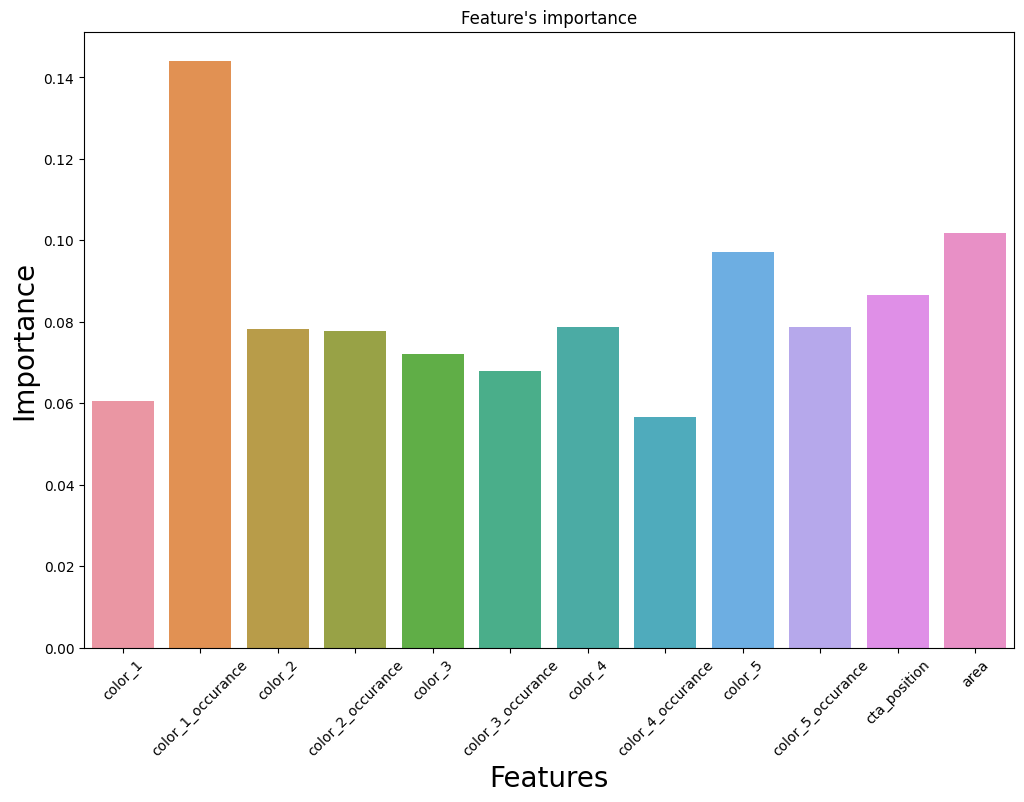

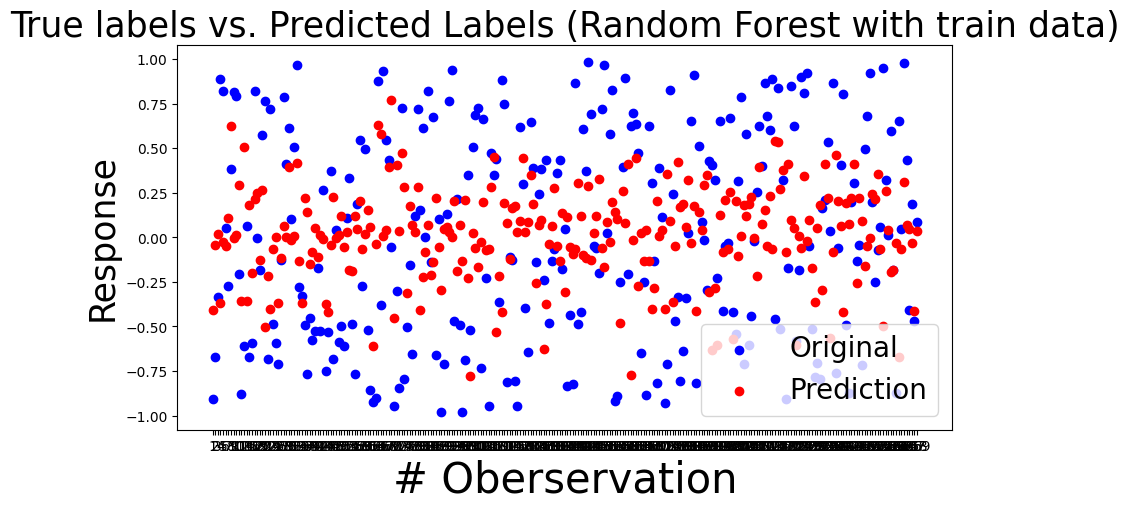

plotted prediction vs true labels
plot_confusion_matrix---------- continuous is not supported
{'RMSE Score': 0.62, 'R2_Squared': -0.16, 'MAE Score': 0.53}
{'Accuracy': 126.19}
{'color_1': 0.06042352523517331, 'color_1_occurance': 0.1440256803348225, 'color_2': 0.0781566997595384, 'color_2_occurance': 0.07774346022671529, 'color_3': 0.07213958116919576, 'color_3_occurance': 0.06793445141107297, 'color_4': 0.07882087307039354, 'color_4_occurance': 0.05665319403082477, 'color_5': 0.0971051570520949, 'color_5_occurance': 0.07871777111012919, 'cta_position': 0.08650758513671888, 'area': 0.1017720214633207}


{'RMSE Score': 0.62, 'R2_Squared': -0.16, 'MAE Score': 0.53}

<Figure size 1200x800 with 0 Axes>

In [59]:
run_train_pipeline(model, X, y, 
    experiment_name='Random Forest with train data',
    run_name='RandomForestRegressor(max_depth=64, random_state=0)')

In [52]:
model = RandomForestRegressor(max_depth=20)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
      
        X, y, test_size=0.2, random_state=123)

In [54]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [55]:
model.score(X_test, y_test)

-0.15986713449493029

In [56]:
pipeline = Pipeline(steps=[('regressor',
 RandomForestRegressor(n_estimators=12, random_state=42))
    ])

model = pipeline.fit(X_train, y_train)

In [57]:
val_accuracy = model.score(X_test, y_test)
val_accuracy

-0.1334789364133091

#### Trying on LSTM

In [80]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


from plot_util import *

In [66]:
def change_datatypes(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    A simple function which changes the data types of the dataframe and returns it
    """
    try:
        data_types = dataframe.dtypes
        changes = ['float64', 'int64']
        for col in data_types.index:
            if(data_types[col] in changes):
                if(data_types[col] == 'float64'):
                    dataframe[col] = pd.to_numeric(
                        dataframe[col], downcast='float')
                elif(data_types[col] == 'int64'):
                    dataframe[col] = pd.to_numeric(
                        dataframe[col], downcast='unsigned')     
    except Exception as e:
        print(e)

    return dataframe

In [67]:
scaled_data = change_datatypes(scale_cols)

In [69]:
SIZE = len(scaled_data.ER)
WINDOW_SIZE = 45 
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [70]:
XTrain = scaled_data.ER.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.ER.values[BATCH_SIZE:].astype('float32')
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set logarithm of sales series:  (804,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [73]:
tf.random.set_seed(0)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([804, 1])

In [74]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [75]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)
# takes a window_size + 1 chunk from the slices

In [76]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

#### Defining and Estimating LTSM

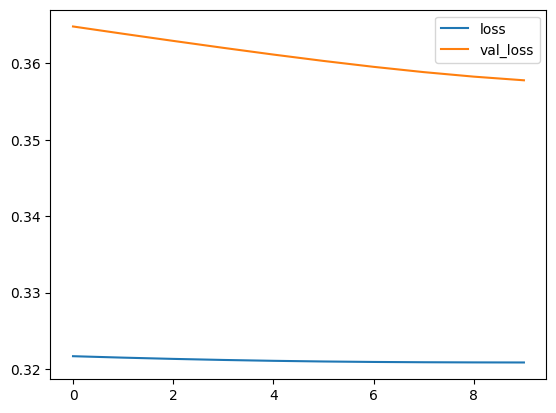

In [81]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [90]:
# Set window of past points for LSTM model
window = 44

# # Split 80/20 into train/test data
last = int(len(scaled_data.ER)/5.0)
Xtrain = scaled_data.ER[:-last]
Xtest = scaled_data.ER[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [91]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [92]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

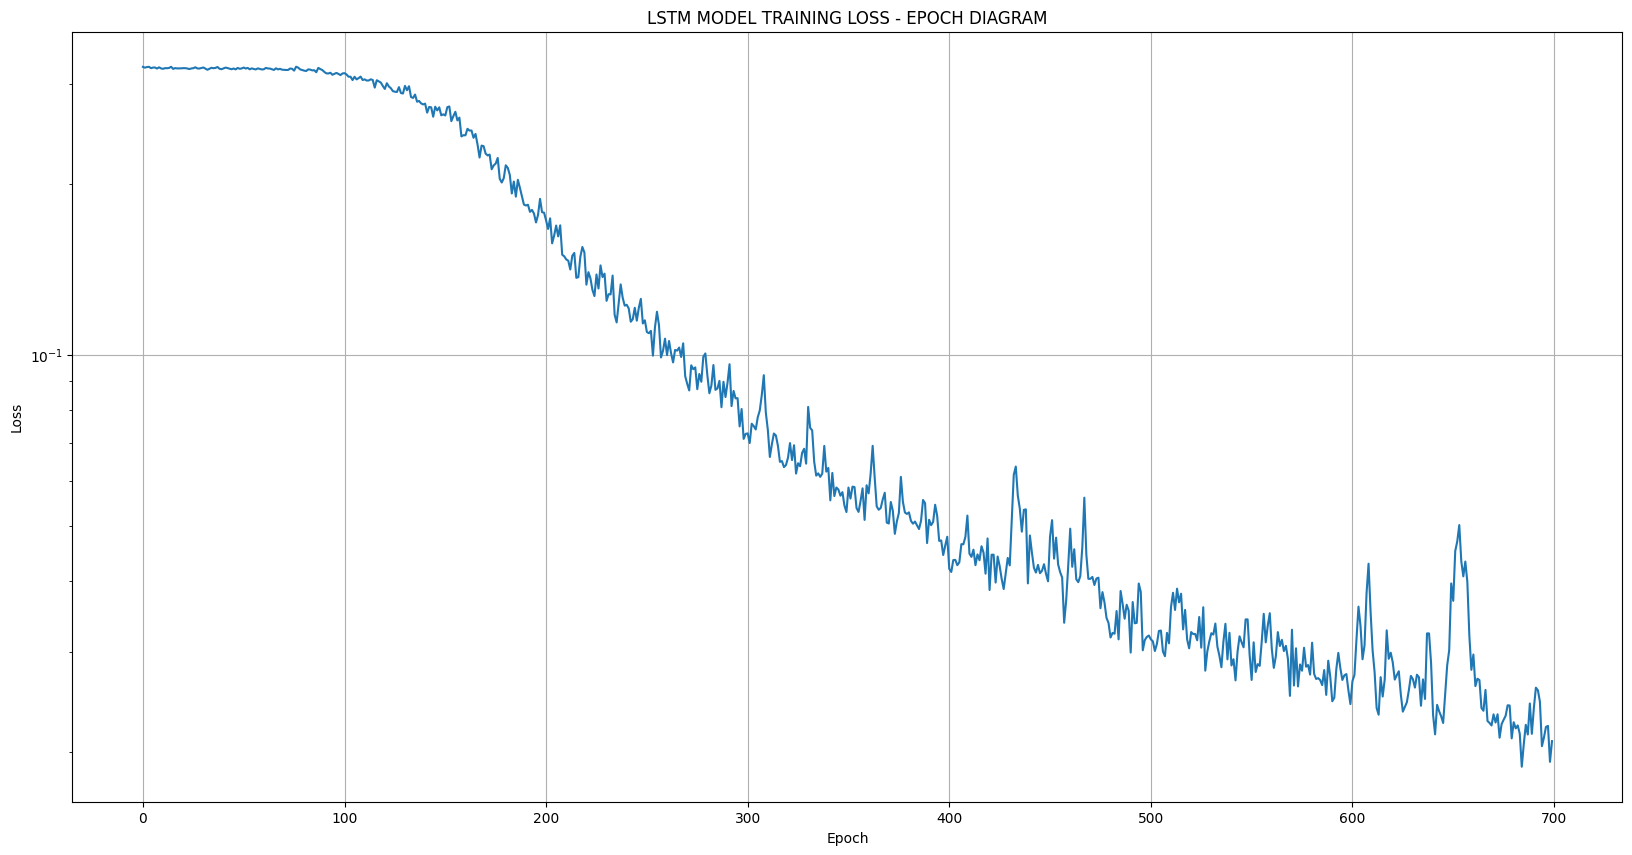

In [93]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [94]:
history.history['loss'][-1]
# Loss value

0.020876962691545486

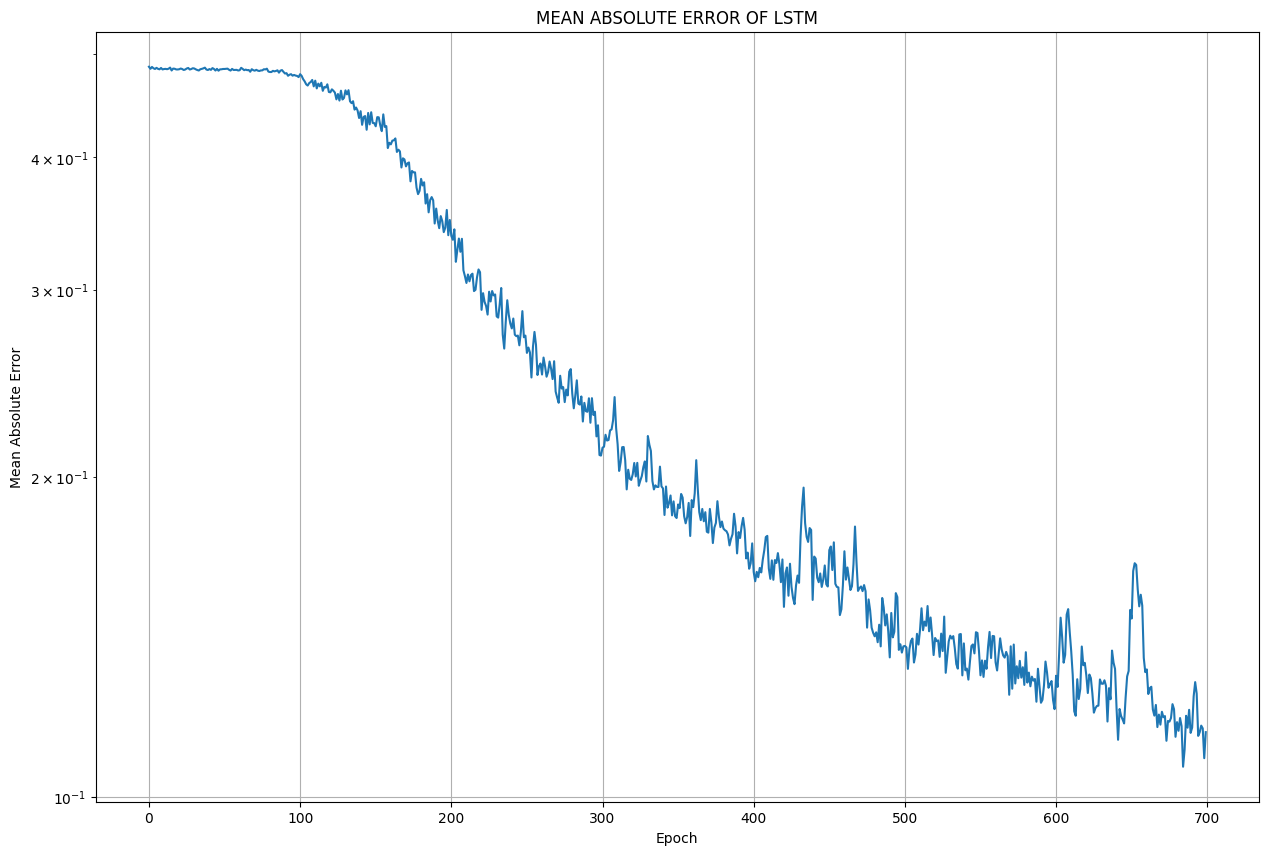

In [110]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [112]:
history.history['mae'][-1]
# Last Mean Absolute Error Value

0.11499814689159393

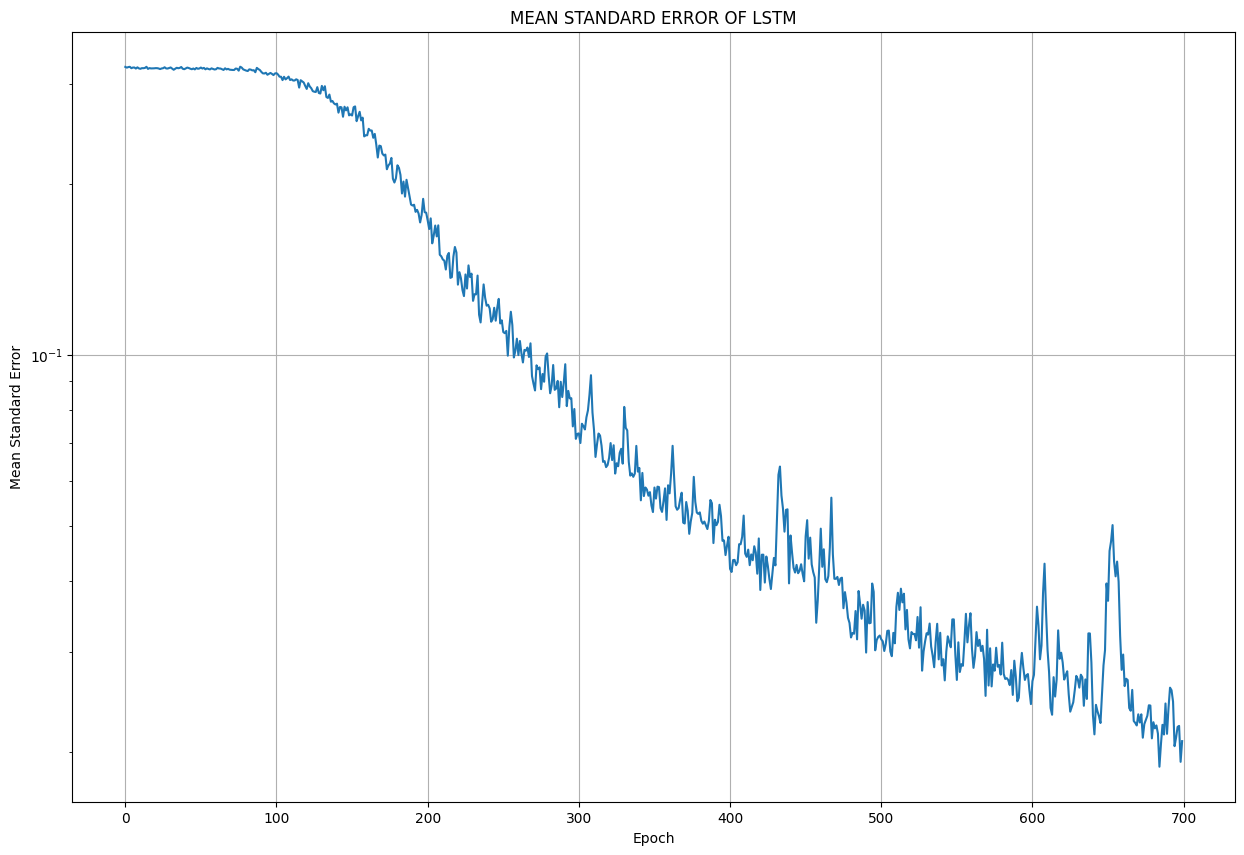

In [135]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN STANDARD ERROR OF LSTM')
plt.ylabel('Mean Standard Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [113]:
history.history['mse'][-1]

0.020876962691545486

#### Save the Model

In [109]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.save(f'../models/LSTM_ER {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-11-06-01:47:47.pkl/assets


INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-11-06-01:47:47.pkl/assets


#### Test model

In [116]:
df_for_model

,color_1,color_1_occurance,color_2,color_2_occurance,color_3,color_3_occurance,color_4,color_4_occurance,color_5,color_5_occurance,ER,CTR,cta_position,area
0,24,502997.0,184,85037.0,177,73722.0,358,66394.0,423,58892.0,0.522940,0.975965,6,540000.0
1,342,274865.0,42,160951.0,336,19223.0,318,14026.0,154,10730.0,0.865483,0.474631,0,11700.0
2,24,499029.0,374,459426.0,426,355211.0,389,278629.0,425,153266.0,0.369275,0.422719,1,25090.0
3,342,271413.0,42,160951.0,336,19223.0,140,10730.0,0,9062.0,0.015088,0.461712,0,11700.0
4,342,490748.0,45,202923.0,309,23779.0,319,23585.0,438,15527.0,0.255562,0.123088,1,19200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,342,274865.0,42,160951.0,336,19223.0,318,14026.0,154,10730.0,0.960574,0.777629,5,11700.0
890,123,8925.0,162,1678.0,185,207.0,259,152.0,386,140.0,0.913909,0.936009,6,20097.0
891,262,516673.0,233,250461.0,432,96128.0,0,87347.0,364,69277.0,0.882153,0.196111,6,10455.0
892,1,266842.0,390,61306.0,266,9600.0,161,9523.0,49,5276.0,0.754836,0.104904,6,10455.0


In [118]:
df_for_model.columns

Index(['color_1', 'color_1_occurance', 'color_2', 'color_2_occurance',
       'color_3', 'color_3_occurance', 'color_4', 'color_4_occurance',
       'color_5', 'color_5_occurance', 'ER', 'CTR', 'cta_position', 'area'],
      dtype='object')

In [123]:
from tensorflow.keras.models import load_model
def predict_tensorflow(df):
    model = load_model('../models/LSTM_ER 2022-11-06-01:47:47.pkl')
    df = df[['color_1', 'color_1_occurance', 'color_2', 'color_2_occurance',
       'color_3', 'color_3_occurance', 'color_4', 'color_4_occurance',
       'color_5', 'color_5_occurance', 'cta_position', 'area']]
    df = np.asarray(df).astype(np.float32)
    result = model.predict(df)
    print(np.exp(result))

In [133]:
df_for_model.head(5)

,color_1,color_1_occurance,color_2,color_2_occurance,color_3,color_3_occurance,color_4,color_4_occurance,color_5,color_5_occurance,ER,CTR,cta_position,area
0,24,502997.0,184,85037.0,177,73722.0,358,66394.0,423,58892.0,0.522940,0.975965,6,540000.0
1,342,274865.0,42,160951.0,336,19223.0,318,14026.0,154,10730.0,0.865483,0.474631,0,11700.0
2,24,499029.0,374,459426.0,426,355211.0,389,278629.0,425,153266.0,0.369275,0.422719,1,25090.0
3,342,271413.0,42,160951.0,336,19223.0,140,10730.0,0,9062.0,0.015088,0.461712,0,11700.0
4,342,490748.0,45,202923.0,309,23779.0,319,23585.0,438,15527.0,0.255562,0.123088,1,19200.0


In [134]:
predict_tensorflow(df_for_model.head(5))

1/1 [==============================] - 1s 662ms/step
[[0.96486205]
 [0.9677656 ]
 [0.96503586]
 [0.96298295]
 [0.96578723]]
